# Julia ecosystems in scientific computing

There are many Julia organizations about seemingly every scientific area. Some examples:

- Astrophysics: [JuliaAstro](https://juliaastro.github.io/), [JuliaSpace](https://github.com/JuliaSpace)
- Bio/Chemistry: [JuliaBio](https://biojulia.net/), [Molecular simulations](https://github.com/JuliaMolSim)
- Complex systems, nonlinear dynamics: [JuliaDynamics](https://juliadynamics.github.io/JuliaDynamics/)
- Differential equations and scientific machine learning: [SciML](https://sciml.ai/)
- Solid state: [QuantumOptics](https://qojulia.org/), [JuliaPhysics](https://github.com/JuliaPhysics)
- Economics: [QuantEcon](https://julia.quantecon.org/), [JuliaQuant](https://github.com/JuliaQuant)
- Geosciences/Climate: [JuliaGeo](https://github.com/JuliaGeo), [JuliaEarth](https://github.com/JuliaEarth), [JuliaClimate](https://github.com/JuliaClimate)
- High energy physics: [JuliaHEP](https://www.juliahep.org/)

among many many others, such as several mathematics-oriented organizations such as optimization, etc.

In this session we will (**very briefly**) overview some powerful Julia packages I found useful for *my own work* and hopefully you will too. Even if the packages relevant for me are not useful in your field, it is still good practice to solve the exercises, to "learn how to learn Julia packages". 

**This session does not attempt to do any _scientific_ teaching. It is likely that some of the things that I'll mention you won't know what they mean. That's okay, because here we are just looking at how some packages work.**

In [2]:
import Pkg
Pkg.activate(@__DIR__)
# Add packages that will be used in this block:
Pkg.add(["OrdinaryDiffEq", "StaticArraysCore", "DynamicalSystems", "DataFrames", "Distributions", "DrWatson", "Query"])
Pkg.status(["OrdinaryDiffEq", "DynamicalSystems", "DataFrames", "Distributions", "DrWatson", "Query"])

  Activating project at `c:\Users\gd419\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop`
   Resolving package versions...


  No Changes to `C:\Users\gd419\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\Project.toml`
  No Changes to `C:\Users\gd419\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\Manifest.toml`


Status `C:\Users\gd419\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop\Project.toml`
  [a93c6f00] DataFrames v1.6.1
⌃ [31c24e10] Distributions v0.25.100
⌃ [634d3b9d] DrWatson v2.12.7
⌃ [61744808] DynamicalSystems v3.2.0
⌃ [1dea7af3] OrdinaryDiffEq v6.53.4
  [1a8c2f83] Query v1.0.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [3]:
# quick theme change for plotting in zoomed-in notebooks
using CairoMakie
update_theme!(resolution = (500, 300), fontsize = 16)

# DifferentialEquations.jl

[DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/dev/index.html) is by far [the best](https://docs.sciml.ai/SciMLBenchmarksOutput/stable/MultiLanguage/ode_wrapper_packages/) free and open source differential equations solver (not just for Julia, for any language): it is orders of magnitude faster and has orders of mangitude more features than anything else out there. It can solve standard ODEs, Delay-DEs, stochastic DEs, PDEs, ADEs, event handling, 1000s of solvers for all tese DEs and many other features. It is the central part of a whole organization focused on scientific machine learning (SciML) and the basis for [ModelingToolkit.jl](https://docs.sciml.ai/ModelingToolkit/dev/), a library for building simulations from symbolic definitions.

Here we will focus on Ordinary Differential Equations (ODEs) solving and use the module `OrdinaryDiffEq` only.

## Defining and solving some ODEs

The way DifferentialEquations.jl works is quite straightforward:

1. Make your set of ODEs a Julia function `f`
2. Put `f`, an initial state and a parameter container into an `ODEProblem`.
2. Choose the solvers and the arguments of the solvers you will use (e.g. tolerances, etc.)
3. Give the `ODEProblem` as well as the auxiliary arguments to the function `solve`!

Let's see it in practice by solving the Thomas cyclical system

$$
\begin{aligned}
\dot{x} &= \sin(y) - bx\\
\dot{y} &= \sin(z) - by\\
\dot{z} &= \sin(x) - bz
\end{aligned}
$$

First step is to make this a Julia function `f`. There are different possibilities on how to define this `f`, but here we will focus on the simplest case, called "out of place". The function function must be in the form `f(u, p, t) -> udot`, which means that given a state `u`, parameters `p` and current time `t` it returns a state vector `udot` containing the rates of change $d\mathbf{x}/dt$. 
For both `u, udot` it is recommended to use **static vectors** `SVector` for ODEs with small number of variables.

In [4]:
using OrdinaryDiffEq
using StaticArraysCore: SVector

function thomas_rule(u, p, t)
    x,y,z = u
    b = p[1]
    xdot = sin(y) - b*x
    ydot = sin(z) - b*y
    zdot = sin(x) - b*z
    return SVector(xdot, ydot, zdot)
end

thomas_rule (generic function with 1 method)

Then set the initial state and parameter container

In [5]:
u₀ = SVector(1.0, 1.0, 2.0)
p₀ = [0.2]

1-element Vector{Float64}:
 0.2

then put everything into the `ODEProblem` structure:

In [6]:
# third argument is the timespan to solve in
timespan = (0.0, 1000.0)
prob = ODEProblem(thomas_rule, u₀, timespan, p₀)

ODEProblem with uType SVector{3, Float64} and tType Float64. In-place: false
timespan: (0.0, 1000.0)
u0: 3-element SVector{3, Float64} with indices SOneTo(3):
 1.0
 1.0
 2.0

Alright, so now we choose the solver algorithm to use. We will discuss this choice in more detail later, but for now we use the default choice of DifferentialEquations.jl.

In [7]:
alg = Tsit5();

Now let's solve the Lorenz system using the default settings of DifferentialEquations.jl (without specifying anything else).

In [8]:
sol = solve(prob; alg) # provide solver algorithm as keyword `alg`

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 813-element Vector{Float64}:
    0.0
    0.1120521120556666
    0.44378050362673405
    0.9136032386187993
    1.4662849360622896
    2.1996084447411617
    3.2045208465180144
    4.085242874574744
    5.129213529677106
    6.241261975411241
    ⋮
  989.016132424067
  990.5662995899445
  992.2501718499245
  993.7379049054462
  995.4297636802733
  996.8774606957784
  998.3576943762309
  999.7917754461864
 1000.0
u: 813-element Vector{SVector{3, Float64}}:
 [1.0, 1.0, 2.0]
 [1.073328946367455, 1.077382180107541, 2.0510228820916896]
 [1.3010643606418302, 1.279441630927924, 2.216402304246613]
 [1.6249069901838225, 1.4855826850617537, 2.4616668952552936]
 [1.9777425718824548, 1.6017467387163078, 2.7100439922221256]
 [2.3894984994256565, 1.599089872828173, 2.8904410244887484]
 [2.8649074514787682, 1.5483523437301538, 2.795240578177487]
 [3.208555980288333, 1.6972897987475106, 2.4194479820781427]
 [3.477822779937590

Okay, so what is the returned result? We didn't specify when to save or anything...

The solver we chose, `Tsit5`, is an _adaptive step solver_. The system is evolved with an adaptive step size, so that the step error tolerance stays below a pre-defined level. The system is evolved until we reach the end of the time span. A state is recorded at every step the solver algorithm takes naturally. E.g. the solution at the third step is

In [9]:
sol.t

813-element Vector{Float64}:
    0.0
    0.1120521120556666
    0.44378050362673405
    0.9136032386187993
    1.4662849360622896
    2.1996084447411617
    3.2045208465180144
    4.085242874574744
    5.129213529677106
    6.241261975411241
    ⋮
  989.016132424067
  990.5662995899445
  992.2501718499245
  993.7379049054462
  995.4297636802733
  996.8774606957784
  998.3576943762309
  999.7917754461864
 1000.0

The solution is guaranteed to start and stop at the limits of the time span (by default).

We can obtain the state at the 3rd time point from the `u` field:

In [10]:
(sol.t[3], sol.u[3])

(0.44378050362673405, [1.3010643606418302, 1.279441630927924, 2.216402304246613])

Because of the mechanics of the solver, `sol` object allows arbitrary interpolation in time by saving some extra derivative-related numbers. This means that we can use `sol` as a function of time, `sol(t)`, to obtain the solution at time `t`

In [11]:
sol(5.6)

3-element SVector{3, Float64} with indices SOneTo(3):
 3.495862759011857
 2.4335212815593588
 1.4402755303498724

We can iterate over some time to create a (multivariate) timeseries

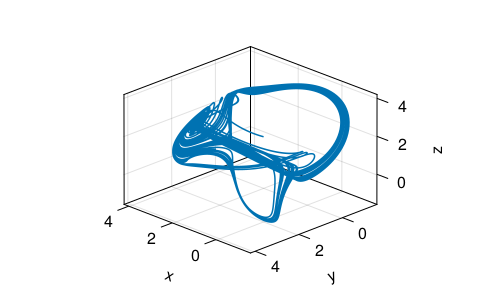

In [12]:
t = timespan[1]:0.1:timespan[end]
X, Y, Z = zero(t), zero(t), zero(t)
for (i, τ) in enumerate(t)
    X[i], Y[i], Z[i] = sol(τ)
end
lines(X, Y, Z; axis = (type = Axis3, azimuth = 0.75π))

Notice that it is possible to skip this advanced feature of interpolation (and thus also skip collecting the extra interpolation-related numbers) and only save at some pre-defined time points by passing the extra keyword argument `saveat = points_I_want` to the `solve` call.

In [13]:
t = timespan[1]:0.1:timespan[end]
sol = solve(prob; alg, saveat = t)
sol.t

10001-element Vector{Float64}:
    0.0
    0.1
    0.2
    0.3
    0.4
    0.5
    0.6
    0.7
    0.8
    0.9
    ⋮
  999.2
  999.3
  999.4
  999.5
  999.6
  999.7
  999.8
  999.9
 1000.0

## Using callbacks for triggering events during time evolution

DifferentialEquations.jl implements a simple interface so that "events" (arbitrary things) can be triggered to after your solution as it is progressing in time. This is done with the [`Callback` interface](https://docs.sciml.ai/DiffEqDocs/dev/features/callback_functions/). For example, a `ContinuousCallback` represents an event that "triggers" when a continuous univariate function of the (state, time) reaches the value 0. Similarly, a `DiscreteCallback` triggers when a Boolean function of the (state, time) evaluates to `true`.

Let's modify the Thomas cyclical system so that a condition triggers each time the third variable becomes zero:


In [14]:
# The third argument of this function is mandatory but too advanced for this lecture
condition(u, t, integrator) = u[3]

condition (generic function with 1 method)

We then define a function that modifies the integrator object. the integrator object is too complicated to explain within this lecture; but we mainly care about the fields `.u` and `.p` that access current state and parameter values. 

In [71]:
function affect!(integrator)
    integrator.u = 1.5integrator.u
end

affect! (generic function with 1 method)

The trigger `condition` and how it will `affect!` the integration are wrapped in continuous callback, which is given to the `solve` call.

In [72]:
cb = ContinuousCallback(condition, affect!);

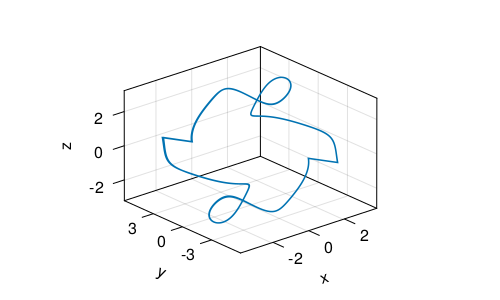

In [73]:
sol = solve(prob; alg, saveat = t, callback = cb)
# plot
lines(sol.u; axis = (type = Axis3,))

## Choosing a solver

So far we have not discussed _how_ the ODE is solved. 
A solver algorithm is chosen when a solution is requested.
So far we have been using `Tsit5`, which is also the overall default that DifferentialEquations.jl uses. But, DifferentialEquations.jl has an impressive list of [100s of solvers one can choose from](https://docs.sciml.ai/DiffEqDocs/dev/solvers/ode_solve/).

Choosing the solver is a problem-dependent operation. We'll cover here two typical examples.




### Higher accuracy, higher order

The solver `Tsit5` is most performant when medium-high error tolerances are requested. When we require very small errors, choosing a different solver can be more accurate. This can be especially impactful for chaotic dynamical systems. Let's first explicitly ask for a given accuracy when solving the ODE by passing the keywords `abstol, reltol` (for absolute and relative tolerance respectively):


In [74]:
sol = solve(prob; alg, saveat = t, abstol = 1e-12, reltol = 1e-12)
sol[end]

3-element SVector{3, Float64} with indices SOneTo(3):
 2.51716935743013
 3.053033609478514
 2.130938443591541

Let's now benchmark how much time it takes to solve the problem with the default `Tsit5` solver:

In [19]:
using BenchmarkTools
@btime solve(prob; alg, saveat = t, abstol = 1e-12, reltol = 1e-12);

  9.504 ms (32 allocations: 719.62 KiB)


Let's see how the higher-order solver `Vern9`, which is better suited for high accuracy, performs:

In [20]:
using BenchmarkTools
@btime solve(prob; alg = Vern9(), saveat = t, abstol = 1e-12, reltol = 1e-12);

  4.777 ms (33 allocations: 720.78 KiB)


## Stiff problems

A "stiff" ODE problem is one that can be numerically unstable unless the step size (or equivalently, the step error tolerances) are extremely small. There are several situations where a problem may be come "stiff":

- The derivative values can get very large for some state values.
- There is a large _timescale separation_ between the dynamics of the variables
- There is a large _timescale separation_ between the dynamics of different state space regions

One must be aware whether this is possible for their system and choose a solver that is better suited to tackle stiff problems. If not, a solution may diverge and the ODE integrator will throw an error or a warning.

  Many of the problems in DifferentialEquations.jl are suitable for dealing with stiff problems, such as `Rodas5P()`. Consult the solver documentation for the possibilities.

# DynamicalSystems.jl
[DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystems.jl/dev/) is an award-winning library for nonlinear dynamics and nonlinear dynamics. It provides functions for analyzing dynamical systems as well as tools for performing nonlinear timeseries analysis.

*Disclaimer: I am one of the developers of this library.*

## Using a dynamical system

Part of the functionality offered by DynamicalSystems.jl utilizes OrdinaryDiffEq.jl to evolve continuous time systems and compute quantities relevant for nonlinear dynamics, such as Lyapunov exponents. Same works for discrete time systems but there there is no need for an external package to evolve them.

Making a `DynamicalSystem` is almost identical to making an `ODEProblem`, but you don't have to specify the time span. In steps:

1. Make $f$ a Julia function (using the same syntax as in OrdinaryDiffEq.jl) representing the dynamic rule of the system.
2. Choose initial state and parameter container (again same as OrdinaryDiffEq.jl).
3. Pass these arguments to the `CoupledODEs` constructor (or `DeterministicIteratedMap`, for discrete systems).

Here we already have `thomas_rule, u₀, p₀` defined above for the Thomas system, which is

$$
\begin{aligned}
\dot{x} &= \sin(y) - bx\\
\dot{y} &= \sin(z) - by\\
\dot{z} &= \sin(x) - bz
\end{aligned}
$$

so to put this in DynamicalSystems.jl is kind of trivial:

In [21]:
using DynamicalSystems
thomas = CoupledODEs(thomas_rule, u₀, p₀)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  thomas_rule
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [0.2]
 time:          0.0
 state:         [1.0, 1.0, 2.0]


Then we can use this `thomas` object in various functions of the library. For example, to obtain the Lyapunov spectrum you use `lyapunovspectrum`:

In [22]:
lyapunovspectrum(thomas, 10000) # 2nd argument is for how much time to evolve

3-element Vector{Float64}:
  0.002080265970671607
 -0.005557932793430255
 -0.5965199974291404

Same story happens if you want to get only the maximum Lyapunov exponent. You use the function `lyapunov` (which uses a different algorithm):

In [23]:
lyapunov(thomas, 10000.0)

0.001914273255323101

Much more advanced behavior is possible. For example, the library has a module dedicated to multistable dynamical systems. We can use it to find all attractors, and their basin state space fraction, for the Thomas system, which becomes multistable at $b = 0.16$. First, we change the system parameter to this $b$ value:

In [75]:
set_parameter!(thomas, 1, 0.16)

And then we utilize `AttractorsViaRecurrences` to find the attractors

In [76]:
# where to search attractors
xg = yg = zg = range(-6, 6; length = 200)
grid = (xg, yg, zg)
mapper = AttractorsViaRecurrences(thomas, grid)
sampler, = statespace_sampler(grid, 12345)
fractions = basins_fractions(mapper, sampler)

Mapping initial conditions to attractors:  92%|██████████|  ETA: 0:00:00

Mapping initial conditions to attractors: 100%|██████████| Time: 0:00:00

Dict{Int64, Float64} with 3 entries:
  2 => 0.302
  3 => 0.364
  1 => 0.334

In [77]:
attractors = extract_attractors(mapper)

Dict{Int32, StateSpaceSet{3, Float64}} with 3 entries:
  2 => 3-dimensional StateSpaceSet{Float64} with 381 points
  3 => 3-dimensional StateSpaceSet{Float64} with 381 points
  1 => 3-dimensional StateSpaceSet{Float64} with 379 points

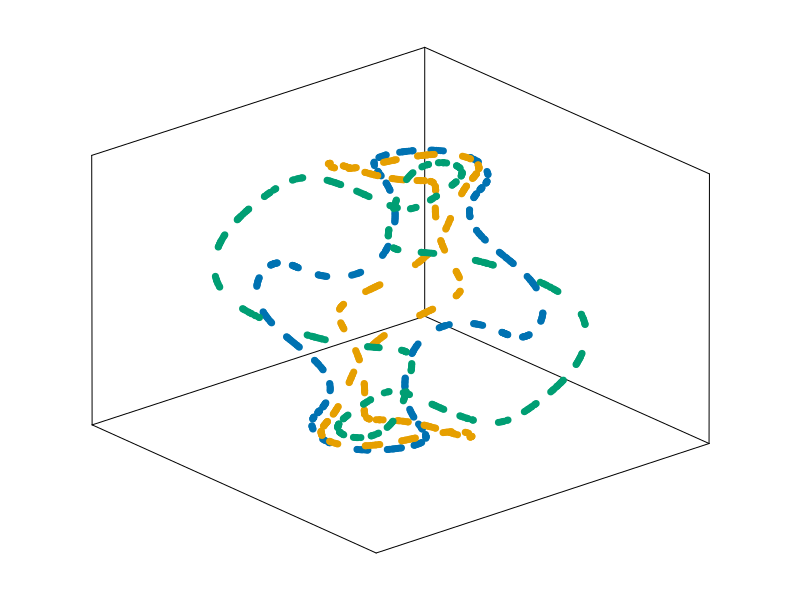

In [78]:
# plot found attractors
fig = Figure(resolution = (800, 600))
ax = Axis3(fig[1,1])
for (k, att) in attractors
    scatter!(ax, vec(att); markersize = 10)
end
hidedecorations!(ax)
fig

In [28]:
# reset parameter to previous one
set_parameter!(thomas, 1, 0.2)

# Optimization with BlackBoxOptim.jl

Julia offers an incredible array of optimization packages. There is an ongoing effort to build a _common interface_ across all optimization packages, which can be found in [Optimization.jl](https://docs.sciml.ai/Optimization/stable/). Here, we will show and use only a single optimization package, [BlackBoxOptim.jl](https://github.com/robertfeldt/BlackBoxOptim.jl), that focuses on blackbox optimization problems where the objective function cannot be defined in terms of simple mathematical equations, and is also not differentiable.

Our goal is to find the parameter combinations for when the following dynamical system
$$
\begin{aligned}
\dot{x} &= -\mu x +yz \\
\dot{y} &= -\mu y +x(z-\alpha) \\
\dot{z} &= 1 - xz
\end{aligned}
$$
(called Rikitake's dynamo) has the largest maximum Lyapunov exponent. 
The computation of Lyapunov exponents is not a process one can straight-forwardly define, or even estimate, derivatives for, hence we turn to blackbox optimization.

To use BlackBoxOptim.jl, we must first define an _objective function_: A  function taking in a vector of parameters and returning the objective we want to minimize;

In [29]:
using DynamicalSystems

# These are the dynamic rules of the dynamical system
function rikitake_rule(u, p, t)
    μ, α = p
    x, y, z = u
    xdot = -μ*x + y*z
    ydot = -μ*y + x*(z - α)
    zdot = 1 - x*y
    return SVector(xdot, ydot, zdot)
end

# This is the objective function:
function minus_lyapunov(p) # input is parameter values
    u0 = SVector(1, 0, 0.6)
    ds = CoupledODEs(rikitake_rule, u0, p)
    λ = lyapunov(ds, 1000; Ttr = 10)
    # return negative exponent because we minimize objective
    return -λ
end

minus_lyapunov (generic function with 1 method)

We will now attempt to "optimize" this objective `minus_lyapunov`, by providing a search range for the input vector `p` (which is the parameter container)

In [30]:
using BlackBoxOptim

μ_range = (0.0, 5.0)
α_range = (-10.0, 10.0)

bbres = bboptimize(minus_lyapunov; SearchRange = [μ_range, α_range], MaxTime = 30.0)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps


0.50 secs, 207 evals, 125 steps, improv/step: 0.368 (last = 0.3680), fitness=-0.301959478


1.00 secs, 391 evals, 277 steps, improv/step: 0.329 (last = 0.2961), fitness=-0.305539557


1.50 secs, 607 evals, 472 steps, improv/step: 0.292 (last = 0.2410), fitness=-0.319292933


2.01 secs, 793 evals, 646 steps, improv/step: 0.282 (last = 0.2529), fitness=-0.324137966


2.51 secs, 958 evals, 807 steps, improv/step: 0.268 (last = 0.2112), fitness=-0.329827119


3.01 secs, 1137 evals, 979 steps, improv/step: 0.248 (last = 0.1570), fitness=-0.329827119


3.52 secs, 1313 evals, 1151 steps, improv/step: 0.231 (last = 0.1337), fitness=

-0.329827119
4.02 secs, 1483 evals, 1321 steps, improv/step: 0.220 (last = 0.1412), fitness=-0.339734315


4.52 secs, 1644 evals, 1482 steps, improv/step: 0.210 (last = 0.1304), fitness=-0.357226747


5.02 secs, 1810 evals, 1648 steps, improv/step: 0.201 (last = 0.1265), fitness=-0.357226747


5.52 secs, 1975 evals, 1813 steps, improv/step: 0.189 (last = 0.0606), fitness=-0.357226747


6.03 secs, 2113 evals, 1951 steps, improv/step: 0.177 (last = 0.0290), fitness=-0.357226747


6.53 secs, 2276 evals, 2114 steps, improv/step: 0.167 (last = 0.0429), fitness=-0.357226747


7.03 secs, 2444 evals, 2282 steps, improv/step: 0.157 (last = 0.0357), fitness=-0.357226747


7.53 secs, 2628 evals, 2466 steps, improv/step: 0.151 (last = 0.0707), fitness=-0.357226747


8.03 secs, 2809 evals, 2647 steps, improv/step: 0.144 (last = 0.0552), fitness=-0.357226747


8.54 secs, 2990 evals, 2828 steps, improv/step: 0.138 (last = 0.0387), fitness=-0.357226747


9.04 secs, 3162 evals, 3000 steps, improv/step: 0.132 (last = 0.0407), fitness=-0.357226747


9.54 secs, 3326 evals, 3164 steps, improv/step: 0.127 (last = 0.0305), fitness=-0.357226747


10.04 secs, 3501 evals, 3339 steps, improv/step: 0.122 (last = 0.0457), fitness=-0.357226747


10.54 secs, 3685 evals, 3523 steps, improv/step: 0.117 (last = 0.0109), fitness=-0.357226747


11.05 secs, 3876 evals, 3714 steps, improv/step: 0.112 (last = 0.0209), fitness=-0.357226747


11.55 secs, 4073 evals, 3911 steps, improv/step: 0.108 (last = 0.0355), fitness=-0.357226747


12.05 secs, 4240 evals, 4078 steps, improv/step: 0.104 (last = 0.0180), fitness=-0.357226747


12.55 secs, 4406 evals, 4244 steps, improv/step: 0.102 (last = 0.0602), fitness=-0.357226747


13.06 secs, 4592 evals, 4430 steps, improv/step: 0.100 (last = 0.0323), fitness=-0.357226747


13.56 secs, 4776 evals, 4614 steps, improv/step: 0.098 (last = 0.0543), fitness=-0.357226747


14.06 secs, 4976 evals, 4814 steps, improv/step: 0.095 (last = 0.0300), fitness=-0.361452417


14.56 secs, 5151 evals, 4989 steps, improv/step: 0.093 (last = 0.0286), fitness=-0.361452417


15.06 secs, 5307 evals, 5145 steps, improv/step: 0.092 (last = 0.0641), fitness=-0.361452417


15.56 secs, 5488 evals, 5326 steps, improv/step: 0.090 (last = 0.0442), fitness=-0.361452417


16.07 secs, 5640 evals, 5478 steps, improv/step: 0.088 (last = 0.0263), fitness=-0.361452417


16.57 secs, 5807 evals, 5645 steps, improv/step: 0.086 (last = 0.0180), fitness=-0.361452417


17.07 secs, 5983 evals, 5821 steps, improv/step: 0.085 (last = 0.0341), fitness=-0.361452417


17.57 secs, 6156 evals, 5994 steps, improv/step: 0.083 (last = 0.0231), fitness=-0.361452417


18.07 secs, 6333 evals, 6171 steps, improv/step: 0.081 (last = 0.0282), fitness=-0.361452417


18.57 secs, 6518 evals, 6357 steps, improv/step: 0.080 (last = 0.0484), fitness=-0.361452417


19.08 secs, 6698 evals, 6538 steps, improv/step: 0.079 (last = 0.0387), fitness=-0.361452417


19.58 secs, 6860 evals, 6700 steps, improv/step: 0.078 (last = 0.0247), fitness=-0.364148107


20.08 secs, 7021 evals, 6862 steps, improv/step: 0.078 (last = 0.0679), fitness=-0.364148107


20.59 secs, 7190 evals, 7032 steps, improv/step: 0.077 (last = 0.0412), fitness=-0.364148107


21.09 secs, 7372 evals, 7228 steps, improv/step: 0.076 (last = 0.0408), fitness=

-0.364148107
21.59 secs, 7556 evals, 7455 steps, improv/step: 0.074 (last = 0.0308), fitness=-0.364148107


22.09 secs, 7745 evals, 7713 steps, improv/step: 0.073 (last = 0.0310), fitness=-0.364148107


22.60 secs, 7934 evals, 7977 steps, improv/step: 0.073 (last = 0.0606), fitness=-0.364148107


23.10 secs, 8121 evals, 8192 steps, improv/step: 0.072 (last = 0.0558), fitness=

-0.364148107
23.60 secs, 8274 evals, 8362 steps, improv/step: 0.072 (last = 0.0529), fitness=-0.364148107


24.10 secs, 8443 evals, 8572 steps, improv/step: 0.072 (last = 0.0619), fitness=-0.364148107


24.60 secs, 8599 evals, 8776 steps, improv/step: 0.071 (last = 0.0686), fitness=-0.364148107


25.10 secs, 8765 evals, 8987 steps, improv/step: 0.072 (last = 0.0806), fitness=-0.364148107


25.61 secs, 8941 evals, 9366 steps, improv/step: 0.070 (last = 0.0211), fitness=-0.364148107


26.11 secs, 9108 evals, 9902 steps, improv/step: 0.067 (last = 0.0205), fitness=-0.364148107



Optimization stopped after 10535 steps and 26.38 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 399.31
Function evals per second = 348.86
Improvements/step = Inf
Total function evaluations = 9204


Best candidate found: 

[0.965876, -9.92018]

Fitness: -0.364148107



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Too many steps (101) without any function evaluations (probably search has converged)", 10535, 1.698757775011e9, 26.383000135421753, ParamsDictChain[ParamsDictChain[Dict{Symbol, Any}(:RngSeed => 199864, :MaxTime => 30.0, :SearchRange => [(0.0, 5.0), (-10.0, 10.0)], :MaxFuncEvals => 0, :MaxSteps => 0),Dict{Symbol, Any}()],Dict{Symbol, Any}(:CallbackInterval => -1.0, :TargetFitness => nothing, :TraceMode => :compact, :FitnessScheme => ScalarFitnessScheme{true}(), :MinDeltaFitnessTolerance => 1.0e-50, :NumDimensions => :NotSpecified, :FitnessTolerance => 1.0e-8, :TraceInterval => 0.5, :MaxStepsWithoutProgress => 10000, :MaxSteps => 10000…)], 9204, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64, Vector{Float64}}(-0.36414810720069546, [0.965875938419552, -9.920181594416812]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}}(FitPopulation{Float64}([0.965875938419552 0.9658759384

In [31]:
pmax = best_candidate(bbres)

2-element Vector{Float64}:
  0.965875938419552
 -9.920181594416812

In [32]:
λmax = -best_fitness(bbres)

0.36414810720069546

Let's also visualize the chaotic attractor for this parameter, because it looks super awesome!

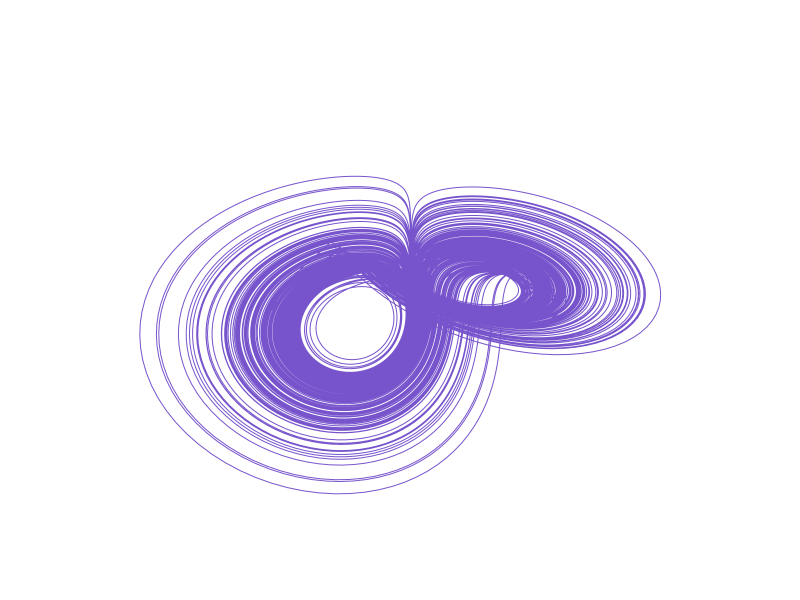

In [79]:
using CairoMakie

ds = CoupledODEs(rikitake_rule, SVector(1, 0, 0.6), pmax)
X, t = trajectory(ds, 1000.0; Ttr = 10, Δt = 0.01)
fig, ax = lines(vec(X);
    linewidth = 1.0, color = "#7754cc",
    axis = (type = Axis3,), figure = (resolution = (800, 600), backgroundcolor = :transparent)
)
ax.azimuth = 2.1
hidedecorations!(ax)
hidespines!(ax)
fig

# Distributions.jl

The [`Distributions`](https://juliastats.org/Distributions.jl/stable/) package provides an interface for writing probability-distribution-agnostic code: sampling distributions and getting pdfs, using moments, and more. This means that you can write any code that uses a probability distribution without having to care about the distribution's specifics. The result: your code can be run with _any_ probability distribution!

> _Note: the package targets applications scenarios where continuous probability density functions with analytically known expressions are used (and optionally fitted to the data). For extracting discrete probability mass functions from input data using a plethora of different discretization methods, see [ComplexityMeasures.jl](https://juliadynamics.github.io/ComplexityMeasures.jl/stable/)._

The way it works is quite straightforward: `Distributions` provides a unified API around abstract types representing probability distributions. To keep things simple here we limit ourselves to univariate continuous distributions.

In [34]:
# import Pkg; Pkg.add("Distributions")
using Distributions
d = Normal(0.1, 0.25)

Normal{Float64}(μ=0.1, σ=0.25)

In [35]:
supertype(typeof(d))

Distribution{Univariate, Continuous}

Various distribution-related quantities can be extracted using `Distributions`, by utilizing the analytic form of a specific distribution. For example:

In [36]:
pdf(d, 0.1) # probability density function at x = 0.1

1.5957691216057308

In [37]:
std(d)

0.25

Arguably one of the most important features for `Distributions` is that these objects can be used as samplers in the `rand` function.

In [38]:
rand(d) # sample a random variable distributed according to `d`

-0.06750761718668083

In [39]:
rand(d, 10, 10)

10×10 Matrix{Float64}:
 -0.650978   -0.293182   -0.0131574   …  -0.286881   -0.0428266   0.262944
 -0.0816717   0.0867363   0.405884        0.670315   -0.236534    0.450978
  0.136374   -0.0332785   0.142474       -0.139372   -0.0586549  -0.00428378
 -0.162881    0.671434    0.119178       -0.192687   -0.036554   -0.295596
  0.315158   -0.128612    0.217063       -0.0123211   0.453147   -0.389983
 -0.0790775  -0.252384   -0.310583    …  -0.298291   -0.45836     0.165785
  0.131267   -0.085049   -0.0566576       0.0553172   0.56478    -0.190724
 -0.10427     0.266713    0.149731       -0.228827    0.0440416  -0.179828
 -0.132224    0.404185   -0.00202169     -0.45901     0.389281    0.17687
 -0.0841871   0.0744026  -0.112157       -0.38585    -0.427496    0.292777

And all of this works for any subtype of `Distribution`:

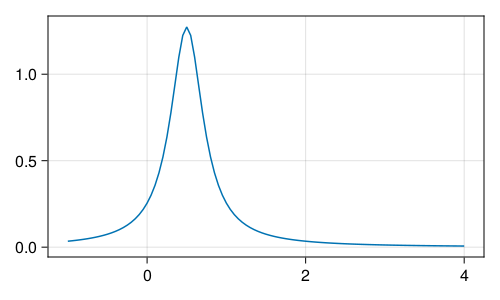

In [40]:
using CairoMakie
cauchy = Cauchy(0.5, 0.25)
x = range(-1, 4; length = 101)
lines(x, pdf.(cauchy, x))

In [41]:
rand(cauchy)

2.5556743272854727

In [42]:
std(cauchy)

NaN

In [43]:
quantile(cauchy, 0.5)

0.5

You can also create your own distribution by extending a small amount of methods!

Or, you can use the `fit` function, to fit a distribution to an e.g. experimental measurement:

In [44]:
x = randn(5000);
cauchyfit = fit(Cauchy, x)

Cauchy{Float64}(μ=-0.0253625840682825, σ=0.6756264377144965)

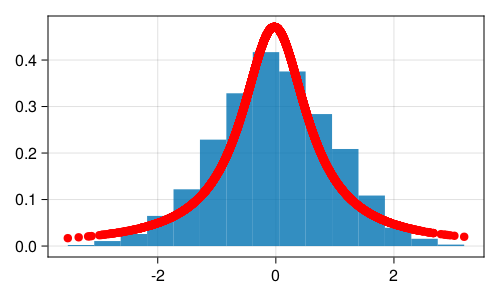

In [45]:
# plot the fit
hist(x, 50; normalization = :pdf)
scatter!(x, pdf.(cauchyfit, x); color = "red")
current_figure()

Of course, other fundamental statistical measures, e.g. means, stds, quantiles, work out of the box for any distribution.

# DrWatson

[DrWatson](https://juliadynamics.github.io/DrWatson.jl/dev/) is a scientific project assistant software. It helps people deal with their scientific code base, allowing them to focus more on the science and less on the code management. DrWatson offers a lot of tools and functionality for this purpose, but here I'll only show a couple of them. 

*Disclaimer: I am one of the developers of DrWatson.*

## FileIO

Obviously, in order to do science, it is necessary to be able to save files to arbitrary formats and to be able to read them later. `FileIO` (which is used by `DrWatson`) is a Julia package that provides a unified API to save and load files to disk, without caring about their actual file ending type.

The interface is as simple as:
```julia
using FileIO
object = load(filename)
save(filename, object)
```
where `filename` is a `String` (arbitrary path) that *includes* the file ending, e.g. `.hdf5`.

`FileIO` does not actually install any packages that can save or load files! It provides the interface. If you try to save/load a file with an unsupported ending, `FileIO` will tell you that's impossible.

In [46]:
using DrWatson
cd(@__DIR__)
pwd() # state current working directory

"c:\\Users\\gd419\\OneDrive - University of Exeter\\Teaching\\Zero2Hero-JuliaWorkshop"

Most packages that can save data of arbitrary format expect the final object to save a dictionary

In [47]:
testdata = Dict("a" => 5, "b" => 4)

Dict{String, Int64} with 2 entries:
  "b" => 4
  "a" => 5

To save the data we need a "file i/o backend". I recommend JLD2.jl:

In [48]:
# import Pkg; Pkg.add("JLD2")
save("test.jld2", testdata)

In [49]:
load("test.jld2")

Dict{String, Any} with 2 entries:
  "b" => 4
  "a" => 5

In [50]:
rm("test.jld2") # clean-up

## Savename

When saving files, scientists often want to include the parameter values of the simulations in the name of the file. For example, If I had run a simulation with parameters:

In [51]:
a, b, c = 1, 2, 3

(1, 2, 3)

I would like to save my simulation as e.g. `sim_a=1_b=2_c=3.jld2`. This can be achieved with string interpolation like so

In [52]:
filename = "sim_a=$(a)_b=$(b)_c=$(c).jld2"

"sim_a=1_b=2_c=3.jld2"

This works, but besides being tedious, it is not extendable: if I have a different simulation, with different parameter names, I have to modify this command.

This is where DrWatson comes in: it provides a tool, called `savename`, that takes as an input **any Julia container** and converts it into a `key=value` chain. It works with dictionaries and arbitrary Julia composite types (it would work with the `Animal` we defined in the previous session). For example:

In [53]:
using DrWatson
# the `@strdict` command makes a dictionary from the given variable names
# it converts the variable names into strings for the keys of the dictionary
# `@strdict` is a "macro", something we won't talk about in this workshop
pars = @strdict a b c

Dict{String, Int64} with 3 entries:
  "c" => 3
  "b" => 2
  "a" => 1

In [54]:
savename(pars)

"a=1_b=2_c=3"

You can also call `savename` with prefix and suffix

In [55]:
model = "linear"
pars = @strdict a b c model
savename("prefix", pars, "jld2")

"prefix_a=1_b=2_c=3_model=linear.jld2"

## Saving tools

DrWatson offers some tools that are useful when saving files. The first is
`tagsave`, which modifies the dictionary-to-be-saved by adding additional information about the current status of the Git repository of the project (if there exists a Git repository). This allows for reproducibility. For example (notice that `pwd()` is the path of a Git repository)

In [56]:
tagsave("test.jld2", copy(pars); gitpath = pwd())
load("test.jld2")

┌ Warning: The Git repository ('c:\Users\gd419\OneDrive - University of Exeter\Teaching\Zero2Hero-JuliaWorkshop') is dirty! Appending -dirty to the commit ID.
└ @ DrWatson C:\Users\gd419\.julia\packages\DrWatson\ieY6i\src\saving_tools.jl:64


Dict{String, Any} with 5 entries:
  "c"         => 3
  "gitcommit" => "abd977c64c18f5614925a4c4ddce3527d3d93b8e-dirty"
  "model"     => "linear"
  "b"         => 2
  "a"         => 1

You can see that the Git commit ID was included in the saved file! And not only that, but because the git status is currently "dirty", this was also added as saved information.

Another useful tool is `safesave`. We all know how **devastating** it can be to by-mistake overwrite an existing simulation because you saved a new simulation with the same name... `safesave` comes to the rescue because it ensures that no files are overwritten but also all files are saved!

It works like this:
```julia
safesave("test.jld2", ...)
```
if `"test.jld2"` exists, rename it to `test_#1.jld2` (and do this recursively if `test_#1.jld2` also exists, by incrementing the number after the `#`). Then, save the current data as `test.jld2`.

In [57]:
safesave("test.jld2", pars)
safesave("test.jld2", pars)
safesave("test.jld2", pars)

In [58]:
readdir(pwd())

19-element Vector{String}:
 ".git"
 ".gitignore"
 "1-JuliaIntro.ipynb"
 "2-MultipleDispatch.ipynb"
 "3-Ecosystem.ipynb"
 "LICENSE.md"
 "Manifest.toml"
 "Project.toml"
 "README.md"
 "add.jpg"
 "makie_ex_fig_1.png"
 "makie_ex_fig_2.png"
 "solutions_1.jl"
 "solutions_2.jl"
 "solutions_3.jl"
 "test.jld2"
 "test_#1.jld2"
 "test_#2.jld2"
 "test_#3.jld2"

In [59]:
# delete all files that end in "jld2"
[rm(f) for f in readdir(pwd()) if endswith(f, "jld2")];

## Collecting results

If you run several similar simulations with different parameters, you typically want to collect all of them in a tabular datastrcture to analyze further. You can use `collect_results` to automate the data collection process. 

Let's say we run first some simulations with varying parameters like so:

In [60]:
model = "linear"
for a in 1:2
    for b in [2, 3]
        # perform a fake simulation
        r = a + b
        # save it:
        p = @strdict a b r model
        s = @strdict a b model # the result "r" doesn't take part in the name
        wsave(joinpath("data", savename(s, "jld2")), p)
    end
end

Then we run a different model, which does not necessarily have the same parameters:

In [61]:
model = "cubic"
for a in 1:2
    for d in [5, 6]
        # perform a fake simulation
        r = a + d^3
        # save it:
        p = @strdict a d r model
        s = @strdict a d model # the result "r" doesn't take part in the name
        wsave(joinpath("data", savename(s, "jld2")), p)
    end
end

Now the idea is that we want to collect all of this results in a single tabular structure. We do with `collect_results(folder)`, which collects all results of the `folder` into a `DataFrame`. This is a tabular data structure (and thus we need the Julia package `DataFrames` to use it):

In [62]:
using DataFrames
results = collect_results("data")

┌ Info: Scanning folder data for result files.
└ @ DrWatson C:\Users\gd419\.julia\packages\DrWatson\ieY6i\src\result_collection.jl:115


┌ Info: Added 8 entries.
└ @ DrWatson C:\Users\gd419\.julia\packages\DrWatson\ieY6i\src\result_collection.jl:191


Row,model,b,r,a,path,d
,String?,Int64?,Int64?,Int64?,String?,Int64?
1,linear,2,3,1,data\\a=1_b=2_model=linear.jld2,missing
2,linear,3,4,1,data\\a=1_b=3_model=linear.jld2,missing
3,cubic,missing,126,1,data\\a=1_d=5_model=cubic.jld2,5
4,cubic,missing,217,1,data\\a=1_d=6_model=cubic.jld2,6
5,linear,2,4,2,data\\a=2_b=2_model=linear.jld2,missing
6,linear,3,5,2,data\\a=2_b=3_model=linear.jld2,missing
7,cubic,missing,127,2,data\\a=2_d=5_model=cubic.jld2,5
8,cubic,missing,218,2,data\\a=2_d=6_model=cubic.jld2,6


So `collect_results` collected all files, but also did something extra, something very useful. Simulation parameters that do not exist in one run (see `b` vs `d`) have the value `missing`. `missing` is how Julia represents missing values.

In [63]:
# delete all saved data files (they are loaded in memory)
rm("data"; recursive = true)

# Tabular data with DataFrames.jl

The `result` that we got above is a `DataFrame` from [DataFrames.jl](http://juliadata.github.io/DataFrames.jl/stable/), one of the major Julia packages for tabular data. 

## Basic stuff
One can do basic selection of these data, for example selecting specific columns, removing columns, adding new columns or rows, etc. The `path` column of the `results` is not so useful, so let's remove it:

In [64]:
select!(results, Not(:path))

Row,model,b,r,a,d
,String?,Int64?,Int64?,Int64?,Int64?
1,linear,2,3,1,missing
2,linear,3,4,1,missing
3,cubic,missing,126,1,5
4,cubic,missing,217,1,6
5,linear,2,4,2,missing
6,linear,3,5,2,missing
7,cubic,missing,127,2,5
8,cubic,missing,218,2,6


To access specific rows or columns you can access a dataframe like a matrix, e.g. `df[:, 1:3]` gives the first three rows while `df[:, [:a, :b]]` gives the rows selected by name.

Adding new data to a dataframe is also straight forward. One can add new rows or new columns. New rows are added by either providing a vector (where the vector's length matches the number of columns), or by providing a named tuple that explicitly names which column gets which new value.

In [65]:
df1 = results[1:3, 1:3]

Row,model,b,r
,String?,Int64?,Int64?
1,linear,2,3
2,linear,3,4
3,cubic,missing,126


In [66]:
# add new row by order of columns
push!(df1, ["test", 5, 5])

Row,model,b,r
,String?,Int64?,Int64?
1,linear,2,3
2,linear,3,4
3,cubic,missing,126
4,test,5,5


In [67]:
# add new row by name of columnns
push!(df1, (model = "test2", r=89, b = -5))

Row,model,b,r
,String?,Int64?,Int64?
1,linear,2,3
2,linear,3,4
3,cubic,missing,126
4,test,5,5
5,test2,-5,89


In [68]:
# add new row with given name by field assignment
df1.z = rand(size(df1, 1))
df1

Row,model,b,r,z
,String?,Int64?,Int64?,Float64
1,linear,2,3,0.254176
2,linear,3,4,0.230651
3,cubic,missing,126,0.629874
4,test,5,5,0.970654
5,test2,-5,89,0.528508


## Querying and manipulating a `DataFrame`

General querying and data manipulation can be done on `DataFrame`s using standard library functions from DataFrames.jl. However, it is [recommended](https://dataframes.juliadata.org/stable/man/querying_frameworks/#Data-manipulation-frameworks) to use a package dedicated to querying and data manupulation that provides simpler/easier syntax for it. Several options exist, each providing a slightly different variant on the syntax, so you can pick whatever you feel most comfortable in. Here we will use a LINQ-like [Query.jl](https://www.queryverse.org/Query.jl/stable/) syntax, which can be used with any tabular Julia data.

In [69]:
using Query
results

Row,model,b,r,a,d
,String?,Int64?,Int64?,Int64?,Int64?
1,linear,2,3,1,missing
2,linear,3,4,1,missing
3,cubic,missing,126,1,5
4,cubic,missing,217,1,6
5,linear,2,4,2,missing
6,linear,3,5,2,missing
7,cubic,missing,127,2,5
8,cubic,missing,218,2,6


Let's perform a basic query that we explain step-by-step:

In [70]:
# `@from ... begin` initializes a query
# here `row` (any name would be fine) is the
# iterable of the tabular data. Think of it as a
# NamedTuple. You can access its values by name with the . syntax
q = @from row in results begin
    # `@where` filters elements where the following
    # expression is true.
    @where row.model == "linear"
    # `@select {stuff... }  creates a new named tuple
    @select {row.a, row.r, rsquared = row.r^2}
    # `@collect` collects the selected results into
    # the specified data structure
    @collect DataFrame
end

Row,a,r,rsquared
,Int64?,Int64?,Int64?
1,1,3,9
2,1,4,16
3,2,4,16
4,2,5,25


As you can see, you don't have to necessarily collect only existing columns, you can even create new ones (specified by name).

Of course, much, much more things are possible to do in such a query. For more, see the documentation of Query.jl.

# A final take-home message

One thing that should really be added a lot of weight, is **how simple, transparent, and high level are the interfaces of everything** that you have seen so far. Both base Julia, as well as most packages for it, have such a simple interface which means that people can learn the software faster and spend more time actually doing science than trying to figure out how to write the code.

This is something that "old" programming languages typically fail at: most (young) people that use codebases written in C/FORTRAN without any high level API defined on top (in e.g. Python) always complain that it is "so hard to use this stuff".
On the other end of the spectrum, packages that are written in Python (while their actual computational code is calling C libraries) are very hard to extend.

Julia = answer :) 

# Exercises

These exercises will require you to search things on the online documentation of the pacakges. (because this is an integral part of the process of "learning a Julia package")


## Bouncing ball

Using the callback functionality of DifferentialEquations.jl, implement the bouncing ball physical system:

$$
\begin{aligned}
\dot{x} &= v \\
\dot{v} &= -g - \gamma v 
\end{aligned}
$$
and at $x=0$ there is a table that the ball bounces from. $g$ is the gravity constant and $\gamma$ the air friction (use e.g. $g=10, \gamma = 0.99, x = 1, v = 0$). Implement this problem for elastic collisions (elastic collisions preserve velocity measure), and plot the time evolution of $x, v$ versus time.

*Hint: whenever the ball reaches the level $x=0$, its velocity should be reversed.*


## Distribution quantile

To find the $q$-th quantile of a distribution, one can use a Newton method

$$\theta_{n+1} = \theta_n -\frac{\text{cdf}(\theta)−q}{\text{pdf}(\theta)}$$

where $\theta_n$ converges to the value of the $q$-th quantile. cdf and pdf are the cumulatide and probability density functions respectively.

Write a generic function that implements the algorithm which calculates the qth quantile of any `UnivariateDistribution` in Distributions.jl, and test your result against the `quantile(d::UnivariateDistribution, q::Number)` function from Distributions.jl using the following distributions: `[Gamma(5, 1), Normal(0, 1), Beta(2, 4)]`.

*Hint: use `θ₀ = mean(distribution)`*



## Plotting subsets of a dataframe

`DataFrames` has a default dataset that is used in its test suite. Install the `CSV` package, and load this dataset with the command:
```julia
using DataFrames, CSV
iris = DataFrame(CSV.File(
    joinpath(dirname(pathof(DataFrames)), 
    "../docs/src/assets/iris.csv")
))
```

This dataset has various flower species (column `:Species`). For every species create a 1x2 figure with the following plots:

* [1,1] = scatter plot of `SepalLength` vs `SepalWidth`. 
* [1,2] = scatter plot of `PetalLength` vs `PetalWidth`.

for each of these sub-scatter plots, calculate and print the Pearson correlaton coefficient.



## DataFrame of chaos

Define the Roessler system as a `DynamicalSystem`:
$$
\begin{aligned}
\dot{x} &= -y-z \\
\dot{y} &= x+ay \\
\dot{z} &= b + z(x-c)
\end{aligned}
$$
with initial condition `ones(3)`. Loop over all three of the following parameter ranges:
```julia
as = 0.15:0.025:0.25
bs = 0.15:0.025:0.25
cs = 4:0.1:6.0
```

and for each parameter combination calculate (1) the Lyapunov spectrum using `lyapunovspectrum` and (2) the Shannon entropy of the system's trajectory. For the entropy, simulate a `trajectory` of the system with sampling time `Δt=0.1` and use `ε=0.1` for the box size when calling `DynamicalSystems.entropy(ValueHistogram(ε), X))`. For changing parameters you have to use `set_parameter!`. Remember that you can push entries to a `DataFrame` row-by-row using `push!(dataframe, (a = a, b = b, ...))`.

Collect this analysis into a dataframe, with columns `a, b, c, λ1, λ3, H` with `λ1, λ3` the first and last elements of `lyapunovspectrum`. Then use the querying framework to query into this dataframe and do the following processes:

####  find chaotic parameter sets
Select all values `a, b, c` where `λ1 > 0.01` (which indicates chaotic dynamics).

####  λ vs H
For all chaotic cases, select the `λ1, H` values and then perform a scatter plot of these two.

#### heatmap of H
For `a` fixed to `0.2`, plot a heatmap of the value of `H` with axis the values of `c` and the values of `b`. Provided that you have a dataframe with columns `:b, :c, :H`, then these commands:
```julia
unstacked = unstack(df, :b,  :H; renamecols = (x -> "H for b=$(x)"))
heat = Matrix(unstacked[:, Not(:c)])
```
will create a matrix with the values of `H` where the row index is the values of `c` and the column index is the values of `b`.

*Hint: you can initiallize an empty dataframe with `df = DataFrame()`, and then start pushing into it arbitrary named tuples like `push!(df, (a = 0.5, b = 0.5))`.*

*Hint 2: this all sounds like a lot of computation, but if you do the exercise correct running all code should not take more than 10 seconds.*


## Textbook optimization problem

Use BlackBoxOptim.jl to find the minimum of the Rozenbrock function, defined as
$$
f(x,y) = (2 - x)^2 + 100(y - x^2)^2
$$
limiting the search range to $x =(-5, 5)$ and $y = (0, 10)$. Confirm that the global minimum is $(2, 4)$.

## Reproducible scientific project
*this exercise only applies to participants that already know Git*

* Use DrWatson's `initialize_project` to start a scientific project somewhere on your computer. 
* Add the packages `JLD2, Distributions` to this project. 
* In the `scripts` folder create a new Julia script that uses three parameters `a, b, c ∈ Reals` and creates a random result `r`. Save this result into disk by using `savename` to produce a name from `a, b, c`, and using `tagsave` to do the actual saving.
* Save your script, and commit it into Git. Then run the script, load the saved file, and confirm that the saved git commit ID matches that of your Git repo.
